  # Autoencoder - SNNL Dev

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
import yaml

import hydra 
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy  
import torch
import torch.nn.functional as F
from torchinfo import summary
import wandb

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
 

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


In [5]:
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace, print_heading, print_underline 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_parameters
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import load_checkpoint_v4,  save_checkpoint_v4

In [6]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-07-09 22:35:40,882 - __main__ - INFO: -  Excution started : 2024_07_09_22:35:40 
2024-07-09 22:35:40,884 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118
2024-07-09 22:35:40,885 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-07-09 22:35:40,886 - __main__ - INFO: -  WandB version    : 0.17.2  		 Pandas version: 2.2.1  


### Hydra

In [7]:
# hydra.core.global_hydra.GlobalHydra.instance().clear()

# abs_config_dir=os.path.abspath("hyperparameters")
# abs_config_dir
# # GlobalHydra.instance().clear() 
# initialize_config_dir(version_base=None, config_dir=abs_config_dir)
# # initialize(version_base=None, config_path="hyperparameters")

# cfg=compose(config_name="AE_Base.yaml")
# type(cfg)
# print(cfg)
# cfgyaml = OmegaConf.to_yaml(cfg)
# type(cfgyaml)
# print(cfgyaml)

### main(args)

In [8]:
WANDB_ACTIVE  = False
LATENT_DIM    = 150
HIDDEN_1      = 512
# HIDDEN_2    = '_256'
HIDDEN_2      = ''
DATE          = 'yymmdd-hhmm'
LOAD_EPOCH    = 200
EPOCHS        = 10
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 0.05
TEMP_LR       = 1.00e-05
CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
CHECKPT

'AE_snnl_dcpb200_150Ltnt_512_yymmdd-hhmm_LAST_ep_200.pt'

In [9]:
# if __name__ == "__main__":
cli_args =   f" --runmode            snnl " \
             f" --configuration      ./hyperparameters/ae_sn_150_512_cpb.yaml" \
             f" --epochs             {EPOCHS} " \
             f" --prim_opt           "\
             f" --lr                 {LEARNING_RATE} "\
             f" --temp_lr            {TEMP_LR}"\
             f" --temp               {TEMP} "\
             f" --temp_annealing     "\
             f" --cpb                {COMPOUNDS_PER_BATCH}" \
	         f" --seed               4321"\
             f" --wandb              "\
             f" --gpu_id             0  "  \
             f" "
             # f" --temp_opt " \
             # f" --ckpt               AE_snnl_dcpb200_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt " \
             # f" --run_id             soucc8ix " \
             # f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
             # f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
             # f" --exp_title           snglOpt-050Ltnt_512_sig "
             # f" --runmode            snnl" \
cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt


Namespace(configuration='./hyperparameters/ae_sn_150_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=10, gpu_id=0, learning_rate=0.0001, exp_id=None, runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=True, use_single_loss=False, temperature=0.05, temperatureLR=1e-05, wandb=True)

2024-07-09 22:35:46,101 - snnl.utils.utils - INFO: -  command line param configuration             : [./hyperparameters/ae_sn_150_512_cpb.yaml]
2024-07-09 22:35:46,102 - snnl.utils.utils - INFO: -  command line param ckpt                      : [None]
2024-07-09 22:35:46,103 - snnl.utils.utils - INFO: -  command line param cpb                       : [200]
2024-07-09 22:35:46,103 - snnl.utils.utils - INFO: -  command line param exp_title                 : [None]
2024-07-09 22:35:46,104 - snnl.utils.utils - INFO: -  command line param epochs                    : [10]
2024-07-09 22:35:46,105 - snnl.utils.utils - INFO: -  command line param gpu_id                    : [0]
2024-07-09 22:35:46,105 - snnl.utils.utils - INFO: -  command line param learning_rate             : [0.0001]
2024-07-09 22:35:46,106 - snnl.utils.utils - INFO: -  command line param exp_id                    : [None]
2024-07-09 22:35:46,107 - snnl.utils.utils - INFO: -  command line param runmode                   : [sn

In [10]:
args

namespace(project_name='CellPainting_Profiles',
          exp_id=None,
          exp_name_pfx=None,
          exp_name=None,
          exp_date=None,
          exp_title='dcpb200_150Ltnt_512',
          exp_description='AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb',
          exp_folder=None,
          folder_sfx=None,
          random_seed=4321,
          units=[['linear', 1471, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 150],
                 ['linear', 150, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 1471]],
          input_shape=1471,
          code_units=150,
          embedding_layer=4,
          show_every=1,
          save_every=100,
          learning_rate=0.0001,
          loss_factor=1.0,
          adam_weight_decay=0,
          snnl_factor=0.5,
          temper

In [11]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device()
    # print(f"Current device is : {current_device}")    
    current_device = set_device(args.gpu_id)
    current_device = get_device()


2024-07-09 22:35:51,196 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-07-09 22:35:51,198 - snnl.utils.utils - INFO: -  Switched to: Quadro GV100 - 0
2024-07-09 22:35:51,199 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100


#### Define dataset and dataloaders

In [12]:
#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

2024-07-09 22:35:52,618 - root - INFO: -  load cellpainting
2024-07-09 22:35:52,620 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-07-09 22:35:52,621 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-07-09 22:35:52,622 - snnl.utils.dataloader - INFO: -  type    :  train
2024-07-09 22:35:52,622 - snnl.utils.dataloader - INFO: -  start   :  0
2024-07-09 22:35:52,623 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-07-09 22:35:52,624 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-07-09 22:35:52,624 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 200.0 compounds with 3 samples per compound : total 600 rows
2024-07-09 22:35:52,625 - snnl.utils.dataloader - INFO: -  Number of 600 row full size batches per epoch: 400
2024-07-09 22:35:52,626 - snnl.utils.dataloader - INFO: -  Rows covered by 400 full size batches (

#### WandB Setup

In [13]:
# args.exp_id   = None
# args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
# args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = None 
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
logger.info(f" args.wandb       : {args.wandb}")
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")

2024-07-09 22:35:55,180 - __main__ - INFO: -  args.wandb       : True
2024-07-09 22:35:55,182 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-07-09 22:35:55,183 - __main__ - INFO: -  Experiment Id    : None
2024-07-09 22:35:55,184 - __main__ - INFO: -  Experiment Name  : None
2024-07-09 22:35:55,185 - __main__ - INFO: -  Experiment Date  : None
2024-07-09 22:35:55,186 - __main__ - INFO: -  Experiment Title : dcpb200_150Ltnt_512
2024-07-09 22:35:55,186 - __main__ - INFO: -  Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb


In [28]:
WANDB_ACTIVE = args.wandb

EXP_DATE = datetime.now().strftime('%y%m%d_%H%M')
args.exp_name = f"AE_{EXP_DATE}"
args.exp_date = EXP_DATE
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")

if WANDB_ACTIVE:
    if args.exp_id is not None:
        print(" *******  Resume W&B Tracking ******* ")
        resume_wandb = True
    else:
        print(" *****  Initialize W&B Tracking ***** ")
        resume_wandb = False
        args.exp_name = f"AE_{EXP_DATE}"
        
    wandb_run = init_wandb(args)
    args.exp_id = wandb_run.id
    wandb_status = " ***** W&B Tracking Started ***** "
else: 
    wandb_status = " ***** W&B Logging INACTIVE ***** "
    args.exp_name = 'AE_'+datetime.now().strftime('%y%m%d_%H%M')
    args.exp_date = datetime.now().strftime('%y%m%d_%H%M')    


logger.info(f" {wandb_status}")
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")

2024-07-09 22:49:10,495 - __main__ - INFO: -  Experiment Name  : AE_240709_2249
2024-07-09 22:49:10,497 - __main__ - INFO: -  Experiment Date  : 240709_2249


 *******  Resume W&B Tracking ******* 


temp_grad_hist,▁
temp_hist,▁
temp_lr,▁
trn_R2_score,▁
trn_R2_score_tev,▁
trn_best_loss,▁
trn_best_loss_ep,▁
trn_best_metric,▁
trn_best_metric_ep,▁
trn_lr,▁
trn_prim_loss,▁


2024-07-09 22:49:18,040 - __main__ - INFO: -   ***** W&B Tracking Started ***** 
2024-07-09 22:49:18,041 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-07-09 22:49:18,043 - __main__ - INFO: -  Experiment Id    : jzt6ecjz
2024-07-09 22:49:18,044 - __main__ - INFO: -  Experiment Name  : AE_240709_2235
2024-07-09 22:49:18,046 - __main__ - INFO: -  Experiment Date  : 240709_2249
2024-07-09 22:49:18,048 - __main__ - INFO: -  Experiment Title : dcpb200_150Ltnt_512
2024-07-09 22:49:18,048 - __main__ - INFO: -  Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 1. Dropping entry: {'trn_best_metric': -9.792330789134146, 'trn_best_metric_ep': 0, 'trn_best_loss': 3.6231201601028444, 'trn_best_loss_ep': 0, 'val_best_metric': -3.519995

# Define autoencoder model

### Override arguments

In [29]:
# args.temperature   = 0.8
# args.loss_factor   = 2.0        ## 2.0e+00
# args.snnl_factor   = 0.5       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 1.0e-04    ## 1e-4
# print(f"   Latent dim        {args.code_units}  \t\t  loss_factor       {args.loss_factor}  \t\t   snnl_factor       {args.snnl_factor}")
# print(f"   temperature       {args.temperature} \t\t  learning_rate     {args.learning_rate} \t\t   temperatureLR:    {args.temperatureLR}")

In [30]:
# list_namespace(args)
args.save_every 

100

## Define Model

In [31]:
model = define_autoencoder_model(args,device = current_device)

if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)

2024-07-09 22:49:25,650 - snnl.utils.utils - INFO: - Defining model in SNNL mode 
2024-07-09 22:49:25,652 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-07-09 22:49:25,668 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-09 22:49:25,669 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-07-09 22:49:25,675 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-09 22:49:25,675 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-07-09 22:49:25,677 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    150  outp

 EMBEDDING LAYER: 4


### Load model checkpoint 

In [32]:
if args.ckpt is not None:
    model.resume_training = True
    model , last_epoch = load_checkpoint_v4(model, args.ckpt, verbose = True )  
    model.train()
    model.device = current_device
    model = model.cuda(device=current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
    model.starting_epoch = last_epoch
    model.ending_epoch = last_epoch + args.epochs
    logging.info(f" RESUME TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

    if 'gen' not in model.training_history:
        print(f" Define self.training_history['gen'] ")
        model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': np.inf, 'trn_best_loss_ep' : 0 ,
                                        'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': np.inf, 'val_best_loss_ep' : 0 }        
    
        for key in ['trn', 'val']:
            tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
            model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
            model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
            
            tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
            model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
            model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
    
else:
    model.resume_training = False
    model.starting_epoch = 0
    model.ending_epoch = args.epochs
    logging.info(f" INITIALIZE TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

model.best_metric = model.training_history['gen'][f'val_best_metric']  
model.best_epoch  = model.training_history['gen'][f'val_best_metric_ep']  

2024-07-09 22:49:27,641 - root - INFO: -  INITIALIZE TRAINING - Run 10 epochs: epoch 1 to 10 


In [33]:
display_model_parameters(model)

if WANDB_ACTIVE:
    wandb.config.update(args)

 Model device           : cuda:0
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : False
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True
 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fc191193b90> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 Use snnl               : True
 SNNL factor            : 0.5
 SNNL temperature       : Parameter containing:
tensor([1.], device='cuda:0', requires_grad

# Autoencoder Fit 

In [34]:
model.starting_epoch, model.ending_epoch = 0, 100
model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(0, 100)

 2024-07-09 22:49:31  epoch    1 of  100


In [ ]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
header = True

for epoch in range(model.starting_epoch, model.ending_epoch):
    train_loss = model.epoch_train(train_loader, epoch, DEBUG_COUNT = 3)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, model.ending_epoch, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y     for x,y in model.training_history['gen'].items()} | \
                        {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if model.new_val_best:
        if WANDB_ACTIVE:
            wandb.unwatch(model)
            save_checkpoint_v4(epoch+1, model, args, update_best=True)  
            wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
        else:
            save_checkpoint_v4(epoch+1, model, args, update_best=True)  
        
    if (epoch + 1) % args.save_every == 0:
        if WANDB_ACTIVE:
            wandb.unwatch(model)
            save_checkpoint_v4(epoch+1, model, args)    
            wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
        else:
            save_checkpoint_v4(epoch+1, model, args)    
            
print(f"Last Epoch {epoch+1}")
if WANDB_ACTIVE:
    wandb.unwatch(model)
    save_checkpoint_v4(epoch+1, model, args, update_latest=True)          
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
else:
    save_checkpoint_v4(epoch+1, model, args)    


 2024-07-09 22:49:31  epoch    1 of  100


2024-07-09 22:51:52,491 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 1


  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
22:51:52  1 /100  |   3.6231     0.7936     2.8295 |   1.000000   0.0000e+00 |  -9.7923     1           |   3.3394     0.5085     2.8309 |  -3.5200     1             |  1.000e-04   0.000e+00 |
22:54:13  2 /100  |   3.2724     0.4380     2.8345 |   1.000000   0.0000e+00 |  -2.4885     2           |   3.2103     0.3715     2.8387 |  -1.1999     2             |  1.000e-04   0.000e+00 |


2024-07-09 22:54:13,421 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 2


22:56:34  3 /100  |   3.1823     0.3420     2.8404 |   1.000000   0.0000e+00 |  -0.8754     3           |   3.1524     0.3104     2.8421 |  -0.5394     3             |  1.000e-04   0.000e+00 |


2024-07-09 22:56:34,401 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 3


22:58:55  4 /100  |   3.1368     0.2941     2.8427 |   1.000000   0.0000e+00 |  -0.2859     4           |   3.1176     0.2741     2.8435 |  -0.0260     4             |  1.000e-04   0.000e+00 |


2024-07-09 22:58:55,805 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 4


23:01:18  5 /100  |   3.1074     0.2636     2.8438 |   1.000000   0.0000e+00 |  -0.0466     5           |   3.0942     0.2499     2.8443 |   0.0839     5             |  1.000e-04   0.000e+00 |


2024-07-09 23:01:18,725 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 5


23:03:38  6 /100  |   3.0871     0.2427     2.8444 |   1.000000   0.0000e+00 |   0.0923     6           |   3.0774     0.2327     2.8447 |   0.2314     6             |  1.000e-04   0.000e+00 |


2024-07-09 23:03:38,709 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 6


23:06:00  7 /100  |   3.0724     0.2276     2.8448 |   1.000000   0.0000e+00 |   0.1985     7           |   3.0649     0.2198     2.8451 |   0.2972     7             |  1.000e-04   0.000e+00 |


2024-07-09 23:06:00,996 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 7


23:08:22  8 /100  |   3.0613     0.2162     2.8451 |   1.000000   0.0000e+00 |   0.2576     8           |   3.0554     0.2101     2.8453 |   0.2156     7             |  1.000e-04   0.000e+00 |
23:10:46  9 /100  |   3.0525     0.2072     2.8453 |   1.000000   0.0000e+00 |   0.3095     9           |   3.0476     0.2021     2.8455 |   0.1844     7             |  1.000e-04   0.000e+00 |
23:13:09 10 /100  |   3.0453     0.1999     2.8454 |   1.000000   0.0000e+00 |   0.3522    10           |   3.0414     0.1957     2.8456 |   0.2485     7             |  1.000e-04   0.000e+00 |
23:15:33 11 /100  |   3.0394     0.1938     2.8456 |   1.000000   0.0000e+00 |   0.3903    11           |   3.0356     0.1899     2.8457 |   0.2999    11             |  1.000e-04   0.000e+00 |


2024-07-09 23:15:33,965 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 11


23:17:59 12 /100  |   3.0341     0.1884     2.8457 |   1.000000   0.0000e+00 |   0.3994    12           |   3.0307     0.1849     2.8458 |   0.2817    11             |  1.000e-04   0.000e+00 |
23:20:23 13 /100  |   3.0291     0.1833     2.8458 |   1.000000   0.0000e+00 |   0.4178    13           |   3.0265     0.1806     2.8459 |   0.3652    13             |  1.000e-04   0.000e+00 |


2024-07-09 23:20:23,862 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 13


23:22:45 14 /100  |   3.0250     0.1792     2.8459 |   1.000000   0.0000e+00 |   0.4242    14           |   3.0226     0.1766     2.8460 |   0.3856    14             |  1.000e-04   0.000e+00 |


2024-07-09 23:22:45,717 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 14


23:25:09 15 /100  |   3.0214     0.1755     2.8459 |   1.000000   0.0000e+00 |   0.4379    15           |   3.0195     0.1734     2.8461 |   0.3870    15             |  1.000e-04   0.000e+00 |


2024-07-09 23:25:10,069 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 15


23:27:32 16 /100  |   3.0182     0.1722     2.8460 |   1.000000   0.0000e+00 |   0.4413    16           |   3.0165     0.1704     2.8461 |   0.4344    16             |  1.000e-04   0.000e+00 |


2024-07-09 23:27:33,146 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 16


23:29:55 17 /100  |   3.0151     0.1691     2.8460 |   1.000000   0.0000e+00 |   0.4553    17           |   3.0137     0.1676     2.8461 |   0.4314    16             |  1.000e-04   0.000e+00 |
23:32:17 18 /100  |   3.0123     0.1662     2.8461 |   1.000000   0.0000e+00 |   0.4712    18           |   3.0111     0.1649     2.8462 |   0.5095    18             |  1.000e-04   0.000e+00 |


2024-07-09 23:32:17,681 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 18


23:34:43 19 /100  |   3.0098     0.1637     2.8461 |   1.000000   0.0000e+00 |   0.4863    19           |   3.0091     0.1629     2.8462 |   0.4938    18             |  1.000e-04   0.000e+00 |
23:37:08 20 /100  |   3.0078     0.1617     2.8461 |   1.000000   0.0000e+00 |   0.5054    20           |   3.0073     0.1610     2.8463 |   0.5186    20             |  1.000e-04   0.000e+00 |


2024-07-09 23:37:08,774 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 20


23:39:32 21 /100  |   3.0058     0.1597     2.8462 |   1.000000   0.0000e+00 |   0.5267    21           |   3.0054     0.1592     2.8463 |   0.5572    21             |  1.000e-04   0.000e+00 |


2024-07-09 23:39:33,298 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 21


23:41:56 22 /100  |   3.0039     0.1577     2.8462 |   1.000000   0.0000e+00 |   0.5538    22           |   3.0042     0.1579     2.8463 |   0.5345    21             |  1.000e-04   0.000e+00 |
23:44:19 23 /100  |   3.0023     0.1561     2.8462 |   1.000000   0.0000e+00 |   0.5726    23           |   3.0027     0.1564     2.8463 |   0.5901    23             |  1.000e-04   0.000e+00 |


2024-07-09 23:44:19,861 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 23


23:46:41 24 /100  |   3.0008     0.1546     2.8462 |   1.000000   0.0000e+00 |   0.5915    24           |   3.0011     0.1547     2.8463 |   0.6197    24             |  1.000e-04   0.000e+00 |


2024-07-09 23:46:42,011 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 24


23:49:05 25 /100  |   2.9998     0.1536     2.8462 |   1.000000   0.0000e+00 |   0.6039    25           |   3.0003     0.1540     2.8463 |   0.6277    25             |  1.000e-04   0.000e+00 |


2024-07-09 23:49:05,927 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240709_2249_BEST.pt - epoch: 25


### Close WandB Logging

In [42]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

temp_grad_hist,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_hist,███████▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_R2_score,▁▆▇▇██▇▇▇▇▇█████████████████████████████
trn_R2_score_tev,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_best_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
trn_best_loss_ep,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trn_best_metric,▁▆▇▇████████████████████████████████████
trn_best_metric_ep,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trn_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_prim_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [43]:
epoch, model.starting_epoch, model.ending_epoch

(399, 300, 400)

In [34]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
17:30:36  1 /300  |   3.6449     0.8119     2.8330 |   1.000000   0.0000e+00 | -11.8533   295           |   3.3535     0.5182     2.8353 |  -4.5372   300             |  1.000e-04   0.000e+00 |
17:32:43  2 /300  |   3.2799     0.4421     2.8378 |   1.000000   0.0000e+00 |  -3.1303   295           |   3.2152     0.3743     2.8409 |  -1.8841   300             |  1.000e-04   0.000e+00 |
17:34:50  3 /300  |   3.1859     0.3438     2.8421 |   1.000000   0.0000e+00 |  -1.3209   295           |   3.1548     0.3114     2.8434 |  -0.7997   300             |  1.000e-04   0.000e+00 |
17:36:58  4 /300  |   3.1386     0.

In [37]:
# model.starting_epoch = 59
# epochs = 100
# model.ending_epoch = 100
model.starting_epoch = model.ending_epoch
model.ending_epoch += 100

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240709_175015  epoch  301 of  400


## Misc stuff

In [ ]:
# save_checkpoint_v3(1, model, args, update_latest=True)  

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature
display_epoch_metrics(model, epoch, model.ending_epoch, header = True)

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
model.state_dict().keys()
# for k in ['temperature', 'snnl_criterion.temperature'
for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
    if model.state_dict()[k].ndim > 1:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
    else:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

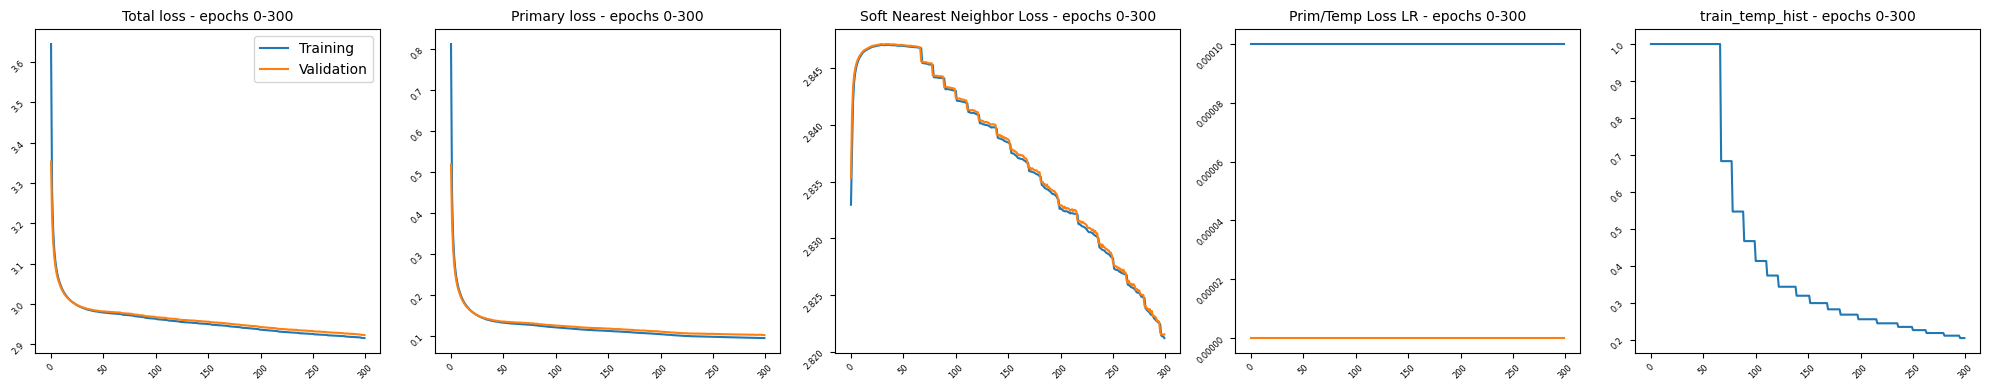

In [35]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

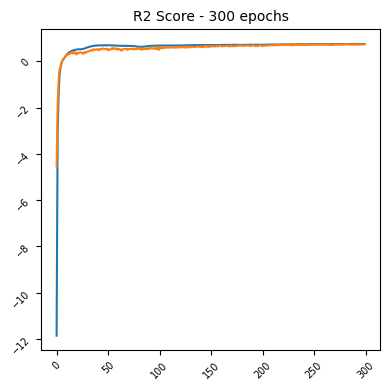

In [36]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
args.compounds_per_batch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [ ]:
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240509'
ex_title = args.exp_title
compounds_per_batch = args.compounds_per_batch


In [ ]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [ ]:
filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"   
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

In [ ]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs, 

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__

# Misc code

In [ ]:
if # model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [ ]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# model.training_history['val'].keys()
# np.argmin(model.training_history['trn']['trn_ttl_loss']), np.min(model.training_history['trn']['trn_ttl_loss'] )
# np.argmin(model.training_history['trn']['trn_prim_loss']),np.min(model.training_history['trn']['trn_prim_loss']), np.min(model.training_history['trn']['trn_prim_loss'])  / model.loss_factor
# np.argmin(model.training_history['trn']['trn_snn_loss']), np.min(model.training_history['trn']['trn_snn_loss'] ),  np.min(model.training_history['trn']['trn_snn_loss'] ) / model.snnl_factor
# print()
# np.argmin(model.training_history['val']['val_ttl_loss']) , np.min(model.training_history['val']['val_ttl_loss'] )
# np.argmin(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']) / model.loss_factor
# np.argmin(model.training_history['val']['val_snn_loss']) , np.min(model.training_history['val']['val_snn_loss'] ), np.min(model.training_history['val']['val_snn_loss'] ) / model.snnl_factor

# model.optimizer
# model.optimizer.state_dict()
# model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr']
# model.scheduler.__dict__

# model.temp_optimizer
# model.temp_scheduler.__dict__
# model.temp_scheduler = model._ReduceLROnPlateau(model.temp_optimizer, mode='min', factor=0.75, patience=35, 
                                              # threshold=1.0e-7, threshold_mode='rel', 
                                              # cooldown=15, min_lr=0, eps=1e-08, verbose =True)  
# model.temp_scheduler['patience'] = 35

In [ ]:
# temp_params = [p for name, p in model.named_parameters() if 'temperature' in name]
# network_params = [p for name, p in model.named_parameters() if 'temperature' not in name]
# for t in temp_params:
#     t.requires_grad = False 

In [ ]:
# model.optimizer = torch.optim.Adam(params = network_params, lr=0.001, weight_decay = 0.1)
# # if self.use_snnl:
# #     self.optimizer.add_param_group({'params': temp_params, 'lr': temperatureLR, 'weight_decay': adam_weight_decay})

# if model.use_scheduler:
#     model.scheduler = model._ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=40, threshold=0.000001, 
#                                              threshold_mode='rel', cooldown=10, min_lr=0, eps=1e-08, verbose =True) 

In [ ]:

if self.use_annealing andd self.best_metric - self.training_history[key][f"{key}_R2_score"][-1] < 1.0e-05:
    self.R2_improvment_counter += 1
    if self.R2_improvement_counter > 10:
        with torch.no_grad():
            self.temperature.copy_(1.0 / ((1.0 + self.temp_decay_counter) ** 0.55))
        self.temp_decay_counter += 1
        self.R2_improvement_counter = 0
        # print(f" {epoch} - anneal temp  -  before: {temp_before:10.6f}     new_temp: {self.temperature.item():10.6f} ")
 